In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sys
import os
# Importing
import gc, os, csv
from catenets.models.jax import TNet, SNet1,SNet2,DRNet
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.abspath('../../data/simulation'))
from utils import tr_te_split,gen_1d_data, backdoor_dgp, frontdoor_dgp, instrument_dgp, simulated_study_2

In [2]:
seed=123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Synthetic data generation process

Generate synthetic data for M=2 outcomes.

1. **Generating Covariates (X)**:
   - A matrix `X` of shape `(N, P)` is generated, where `N` is the number of samples and `P` is the number of features. $X_{i,j} \sim Unif(-3,3)$ for $j \in \{1,2,...,P\}$ and $i \in \{1,2,...,N\}$. 

2. **Generate action allocation policy**
   - The action allocation policy is simulated according to a multinomial distribution where the probabilities of being assigned to action $A_i$ = a are generated as a softmax function of the covariates
   - $$P(A_i = a |X_i=x_i) = \frac{exp\{X_i \beta_a\}}{\sum_{a \in A} exp\{X_i \beta_a\}}$$
   - $\beta_a$ is an action-specific P-dimensional sparse vector of action-specific coefficients defined as follow:
        - $\beta_1 = [-1, -0.8, -0.1, -0.1, 0, \ldots, 0]$
        - $\beta_2 = [0, 0, 1, 0.8, 0.2, 0, \ldots, 0]$
      <!--
        - $\beta_3 = [1.5, -0.8, -0.1, -0.1, 0, \ldots, 0]$
        - $\beta_4 = [-1, -0.8, -0.1, -0.1, 0, \ldots, 0]$ -->

3. **Generating Outcomes (Y) and Costs (C)**:

    - Thus \( A_i \) is drawn from a multinomial with vector probabilities parameter $p(A_i = a|X_i = x_i)$. The $M = 2$ action-specific correlated counterfactual outcomes $Y_i | do(A_i = a)$ instead are generated as

    - $Y_i | do(A_i = a) = f_{Y_a} (X_i) + e_i, \quad e_i \sim N(0, \Sigma_{e_i})$

    - where:
        - $f_{y11} = 3 + 0.4X_0X_1 - 0.3X_2^2 + 0.2 \exp(X_3) + 0.6 \sin(X_4)$
        - $f_{y12} = -1 + f_{y11} + 0.1X_5$
        - $f_{y21} = 1 + 0.2X_0X_1 - 0.2X_2^2 + 0.1 \exp(X_3)$
        - $f_{y22} = -2 + f_{y21} + 0.2X_5$
        - where $diag(\Sigma_{e_i}) = [\sigma_1, ..., \sigma_4]$, with $\sigma_1 = ... = \sigma_4 = 0.5$
      <!--
        - $f_{y13} = 1 + f_{y11} + 0.3X_5$
        - $f_{y14} = 0.5 + f_{y11} + 0.5X_6$
        - $f_{y21} = 1 + 0.2X_0X_1 - 0.2X_2^2 + 0.1 \exp(X_3)$
        - $f_{y22} = -2 + f_{y21} + 0.2X_5$
        - $f_{y23} = 2 + f_{y21} + 0.4X_5$
        - $f_{y24} = 1 + f_{y21} + 0.5X_6$
        - where $diag(\Sigma_{e_i}) = [\sigma_1, ..., \sigma_4]$, with $\sigma_1 = ... = \sigma_4 = 0.5$

In [3]:
# Define the two-layer MLP for Experts
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the two-layer MLP for Gates
class Gate(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_experts)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

In [4]:
# Define the Mixture of Experts Model
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, hidden_dim, expert_output_dim, num_experts, num_tasks):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim, expert_output_dim) for _ in range(num_experts)])
        self.gates = nn.ModuleDict({
            f"task_{task}_treatment_{treatment}": Gate(input_dim, hidden_dim, num_experts)
            for task in range(num_tasks) for treatment in range(2)
        })
        self.task_heads = nn.ModuleDict({
            f"task_{task}_treatment_{treatment}": nn.Linear(expert_output_dim, 1)
            for task in range(num_tasks) for treatment in range(2)
        })

    def forward(self, x):
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=-1)  # Shape: (batch_size, expert_output_dim, num_experts)
        outputs = {}

        for key, gate in self.gates.items():
            gate_weights = gate(x)  # Shape: (batch_size, num_experts)
            gate_weights = gate_weights.unsqueeze(1)  # Shape: (batch_size, 1, num_experts)
            mixture_output = torch.bmm(expert_outputs, gate_weights.transpose(1, 2)).squeeze(2)  # Shape: (batch_size, expert_output_dim)
            task_output = self.task_heads[key](mixture_output)  # Shape: (batch_size, 1)
            outputs[key] = task_output

        return outputs

## Simple MTML

In [14]:
def train_mixture_of_experts(input_dim=10, hidden_dim=20, expert_output_dim=5, num_experts=3, num_tasks=2, epochs=200, N=1000, batch_size=64, learning_rate=0.001, seed=42):
    # Generate Data

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    P = input_dim
    X, A, Y, C, Y_true, C_true = backdoor_dgp(N=N, P=P, rng=seed)

    # Initialize Mixture of Experts model
    model = MixtureOfExperts(input_dim, hidden_dim, expert_output_dim, num_experts, num_tasks)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Train-Test Split (80-20%)
    split = np.random.choice(np.array([True, False]), N, replace=True, p=np.array([0.8, 0.2]))
    X_train, X_test = tr_te_split(X, split)
    A_train, A_test = tr_te_split(A, split)
    Y_train, Y_test = tr_te_split(Y, split)
    C_train, C_test = tr_te_split(C, split)
    Y_true_train, Y_true_test = tr_te_split(Y_true, split)
    C_true_train, C_true_test = tr_te_split(C_true, split)

    Y_true_test_cate = Y_true_test[:, 1] - Y_true_test[:, 0]
    C_true_test_cate = C_true_test[:, 1] - C_true_test[:, 0]

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    A_train_tensor = torch.tensor(A_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    C_train_tensor = torch.tensor(C_train, dtype=torch.float32)

    # Create DataLoader for batch training
    dataset = TensorDataset(X_train_tensor, A_train_tensor, Y_train_tensor, C_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop with batches
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, A_batch, Y_batch, C_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = 0

            # Compute loss for each task and treatment using the treatment indicator A
            for i in range(X_batch.size(0)):
                treatment = int(A_batch[i].item())
                y_key = f"task_0_treatment_{treatment}"
                c_key = f"task_1_treatment_{treatment}"

                y_true_values = Y_batch[i].unsqueeze(0)
                y_predicted_values = outputs[y_key][i]
                loss += loss_fn(y_predicted_values, y_true_values)

                c_true_values = C_batch[i].unsqueeze(0)
                c_predicted_values = outputs[c_key][i]
                loss += loss_fn(c_predicted_values, c_true_values)

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss /(batch_size*len(dataloader))}")

    # Evaluate model on test data
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X_test, dtype=torch.float32))

    # Extracting example outputs for causal estimation
    y_a_0 = outputs["task_0_treatment_0"].detach().numpy().flatten()
    y_a_1 = outputs["task_0_treatment_1"].detach().numpy().flatten()
    y_b_0 = outputs["task_1_treatment_0"].detach().numpy().flatten()
    y_b_1 = outputs["task_1_treatment_1"].detach().numpy().flatten()

    cate_pred_y = y_a_1 - y_a_0
    cate_pred_c = y_b_1 - y_b_0

    # Compute RMSE for the treatment effects predicted by model_y and model_c
    rmse_y = np.sqrt(mean_squared_error(Y_true_test_cate, cate_pred_y))
    rmse_c = np.sqrt(mean_squared_error(C_true_test_cate, cate_pred_c))

    print("RMSE for treatment effect by t_Y:", rmse_y)
    print("RMSE for treatment effect by t_C:", rmse_c)

    # Plotting for the last element in N
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(Y_true_test_cate, cate_pred_y, alpha=0.5)
    plt.plot([Y_true_test_cate.min(), Y_true_test_cate.max()], [Y_true_test_cate.min(), Y_true_test_cate.max()], 'k--')
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE ($t_Y$)')
    plt.title('True vs Predicted CATE (Model $t_Y$)')

    plt.subplot(1, 2, 2)
    plt.scatter(C_true_test_cate, cate_pred_c, alpha=0.5)
    plt.plot([C_true_test_cate.min(), C_true_test_cate.max()], [C_true_test_cate.min(), C_true_test_cate.max()], 'k--')
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE ($t_C$)')
    plt.title('True vs Predicted CATE (Model $t_C$)')

    plt.show()

## N = 1000

Epoch 0, Loss: 8.960351773670741
Epoch 10, Loss: 8.56175800732204
Epoch 20, Loss: 8.154028075081962
Epoch 30, Loss: 7.7178361756461005
Epoch 40, Loss: 7.243359582764762
Epoch 50, Loss: 6.7201313972473145
Epoch 60, Loss: 6.153115766389029
Epoch 70, Loss: 5.565641573497227
Epoch 80, Loss: 5.006277748516628
Epoch 90, Loss: 4.511130111558097
RMSE for treatment effect by t_Y: 0.5929635843282945
RMSE for treatment effect by t_C: 0.7076497224692532


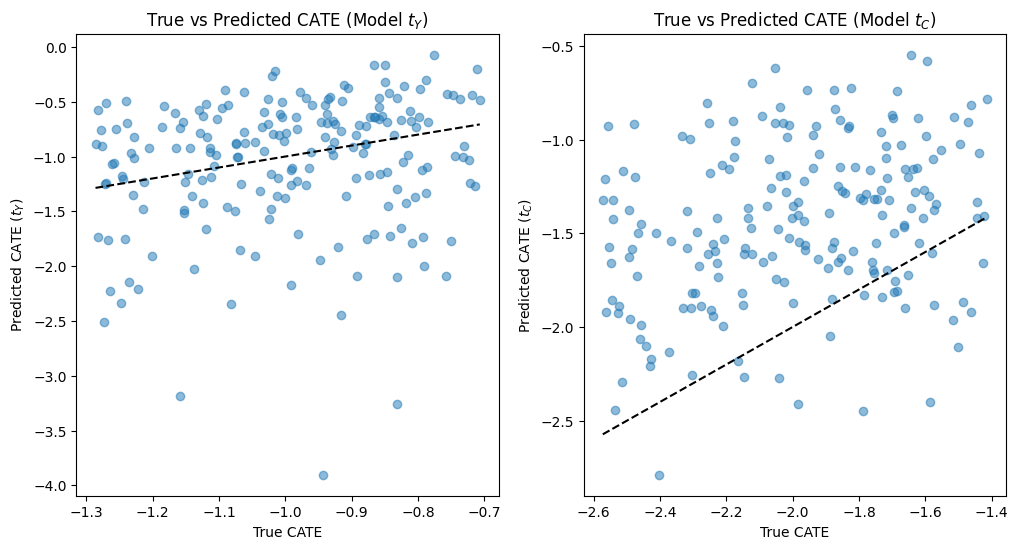

In [15]:
train_mixture_of_experts(input_dim=10, hidden_dim=20, \
                         expert_output_dim=5, num_experts=10, \
                         num_tasks=2, epochs=100, N=1000, batch_size=128, \
                         learning_rate=0.0001, seed=123)

## N = 1500

Epoch 0, Loss: 9.075620102882386
Epoch 10, Loss: 3.2762105107307433
Epoch 20, Loss: 2.095802402496338
Epoch 30, Loss: 1.624664556980133
Epoch 40, Loss: 1.2526059091091155
Epoch 50, Loss: 0.9247059941291809
Epoch 60, Loss: 0.7077302992343902
Epoch 70, Loss: 0.5890771001577377
Epoch 80, Loss: 0.5143266394734383
Epoch 90, Loss: 0.465653233230114
RMSE for treatment effect by t_Y: 0.9243582006707747
RMSE for treatment effect by t_C: 0.7079554359997307


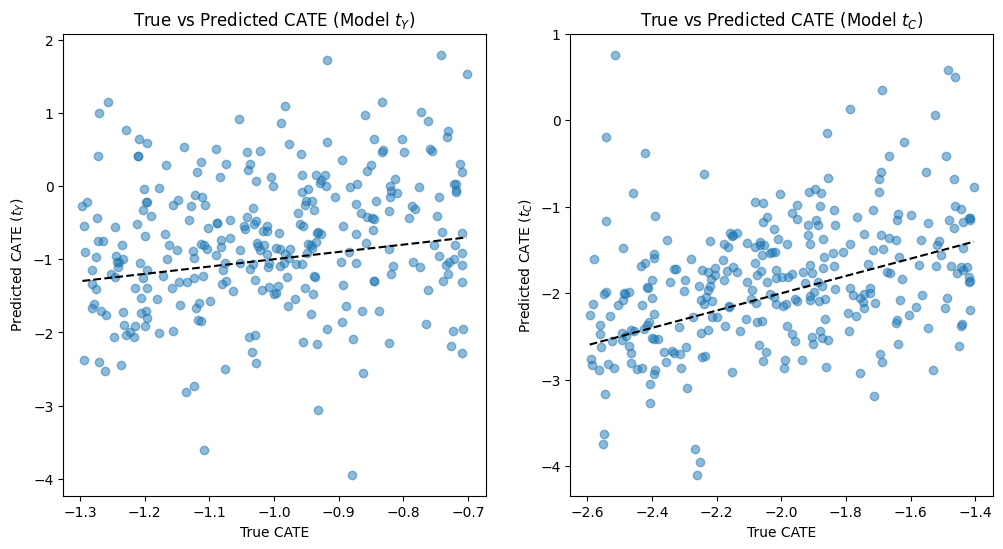

In [34]:
train_mixture_of_experts(input_dim=10, hidden_dim=20, \
                         expert_output_dim=5, num_experts=10, \
                         num_tasks=2, epochs=100, N=1500, batch_size=128, \
                         learning_rate=0.001, seed=123)

## N = 2000

Epoch 0, Loss: 9.250878664163443
Epoch 10, Loss: 2.7469288936028113
Epoch 20, Loss: 1.915259783084576
Epoch 30, Loss: 1.3805847672315745
Epoch 40, Loss: 0.9106413951286902
RMSE for treatment effect by t_Y: 0.9419417995071829
RMSE for treatment effect by t_C: 0.6811906022626887


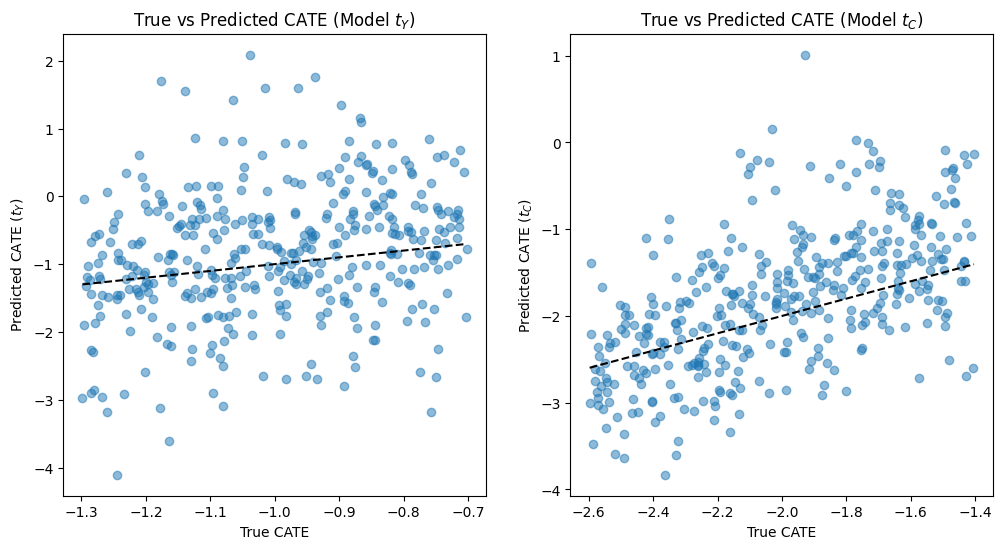

In [35]:
train_mixture_of_experts(input_dim=10, hidden_dim=20, \
                         expert_output_dim=5, num_experts=10, \
                         num_tasks=2, epochs=50, N=2000, batch_size=128, \
                         learning_rate=0.001, seed=123)

## N = 2500

Epoch 0, Loss: 9.226441442966461
Epoch 10, Loss: 2.451834224164486
Epoch 20, Loss: 1.5964246839284897
Epoch 30, Loss: 1.0047784075140953
Epoch 40, Loss: 0.7088942620903254
Epoch 50, Loss: 0.5878303218632936
Epoch 60, Loss: 0.527145516127348
Epoch 70, Loss: 0.485606437548995
Epoch 80, Loss: 0.4598356280475855
Epoch 90, Loss: 0.43501601554453373
RMSE for treatment effect by t_Y: 0.6455871935932793
RMSE for treatment effect by t_C: 0.5270400464381819


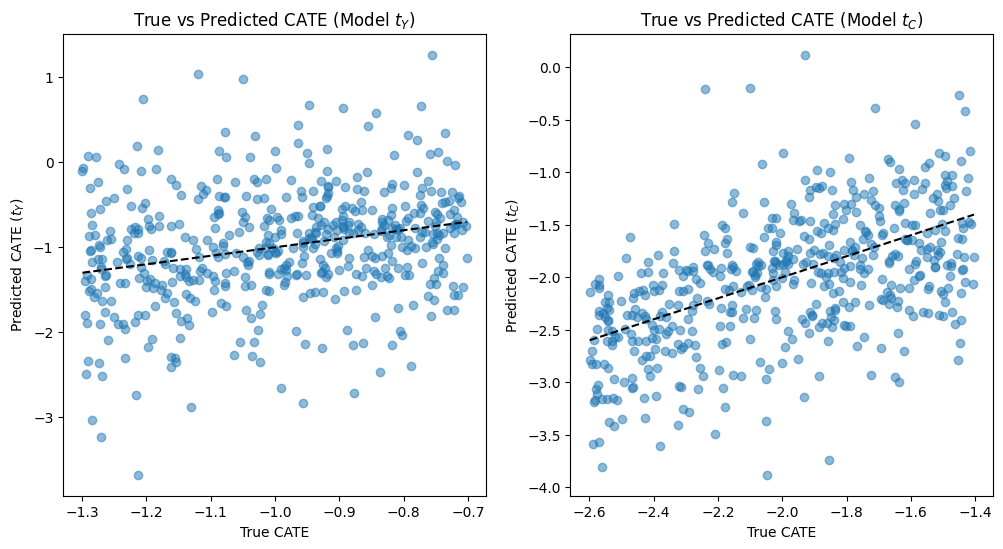

In [36]:
train_mixture_of_experts(input_dim=10, hidden_dim=20, \
                         expert_output_dim=5, num_experts=10, \
                         num_tasks=2, epochs=100, N=2500, batch_size=128, \
                         learning_rate=0.001, seed=123)

## N = 3000

Epoch 0, Loss: 9.334680230993973
Epoch 10, Loss: 2.2826366424560547
Epoch 20, Loss: 1.378153305304678
Epoch 30, Loss: 0.7841052946291471
Epoch 40, Loss: 0.6080531587726191
Epoch 50, Loss: 0.5336678357500779
Epoch 60, Loss: 0.4926280755745737
Epoch 70, Loss: 0.45981841181453903
Epoch 80, Loss: 0.4319676129441512
Epoch 90, Loss: 0.41285727996575206
Epoch 100, Loss: 0.3917214854767448
Epoch 110, Loss: 0.37523680768514933
RMSE for treatment effect by t_Y: 0.6879118185974759
RMSE for treatment effect by t_C: 0.564994793857179


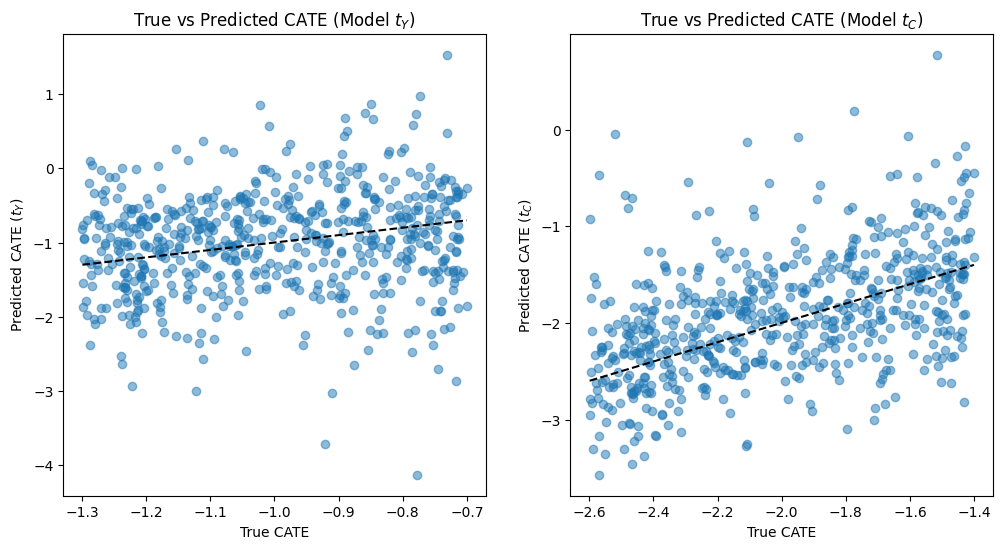

In [39]:
train_mixture_of_experts(input_dim=10, hidden_dim=20, \
                         expert_output_dim=5, num_experts=10, \
                         num_tasks=2, epochs=120, N=3000, batch_size=128, \
                         learning_rate=0.001, seed=123)